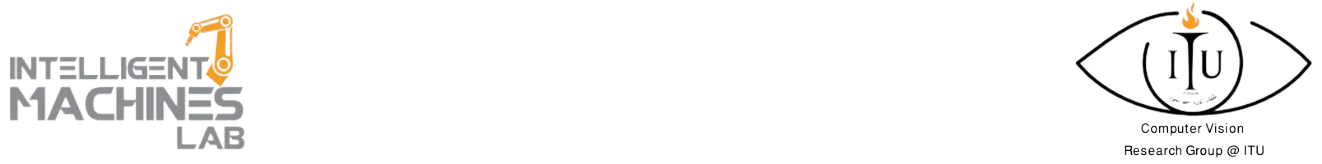

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Ahmed Haroon`

Reg No: `MSDS24004`

Github Link: `https://github.com/yesahmedyes/Generative-AI-LLMs`

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import datasets, transforms
import torch.optim as optim

from torch.utils.data import DataLoader

# Model Definition

In [88]:
def weights_init(m):
    # Use He Initialization and use this function to initialize the weights of the model

    if (
        isinstance(m, nn.Conv2d)
        or isinstance(m, nn.ConvTranspose2d)
        or isinstance(m, nn.Linear)
    ):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
    if hasattr(m, "bias") and m.bias is not None:
        nn.init.constant_(m.bias, 0)


class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        # Initialize the encoder Layers
        # You encoder will have 2 convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the encoder will be flattened to a single vector

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, h_dims[0], kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dims[0], h_dims[1], kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Encoder Output Size should be 64 * 7 * 7

        # Initialize the FC layers to output the mean and log variance

        self.fc_input_size = h_dims[1] * 7 * 7

        self.fc_mu = nn.Linear(self.fc_input_size, latent_dims)
        self.fc_logvar = nn.Linear(self.fc_input_size, latent_dims)

        # Initialize the decoder layers
        # The decoder will have 2 transposed convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the decoder will be a tensor of the same size as the input

        self.fc_decoder = nn.Linear(latent_dims, self.fc_input_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                h_dims[1],
                h_dims[0],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                h_dims[0],
                input_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.Sigmoid(),
        )

        # Decoder Output Size should be 64 * 28 * 28

        # Apply weight initialization using the weights_init function

        self.apply(weights_init)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # Implement the reparametrization trick. Notice the input argument is logvar and not sigma. This is to prevent overflow

        std = torch.exp(0.5 * logvar)
        e = torch.randn_like(std)

        return mu + std * e

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # Implement the encoding process

        z = self.encoder(x)

        z = z.view(z.size(0), -1)

        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)

        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        # Implement the decoding process

        x = self.fc_decoder(z)

        x = x.view(x.size(0), -1, 7, 7)

        x = self.decoder(x)

        return x

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # Implement the forward pass

        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_reconstructed = self.decode(z)

        return x_reconstructed, mu, logvar


# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28

model = CNN_VAE(input_channels=INPUT_CHANNELS)

output, mu, logvar = model.forward(
    torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE))
)

print(output.shape)

torch.Size([1, 1, 28, 28])


# Dataset Loading

In [100]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

INPUT_DIMS = 1

HID_DIMS = [32, 64]

Z_DIMS = 20

NUM_EPOCHS = 10

LR = 3e-4

BATCH_SIZE = 64

VAL_AFTER = 800

In [101]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor(),)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor(),)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

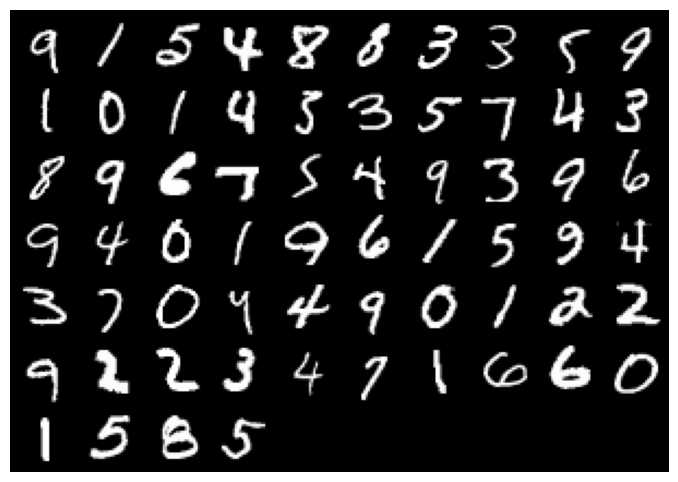

In [103]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

plot_image(images)

# Training Loop

In [104]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_divergence

In [105]:
from tqdm import tqdm



# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.

model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
eval_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    
    train_loss = 0

    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        data = data.to(DEVICE)

        reconstructed_x, mu, logvar = model(data)

        loss = vae_loss(reconstructed_x, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()

    eval_loss = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(DEVICE)

            reconstructed_x, mu, logvar = model(data)

            loss = vae_loss(reconstructed_x, data, mu, logvar)
            eval_loss += loss.item()
            
    eval_losses.append(eval_loss / len(test_loader.dataset))
    
    print("Train Loss: %.2f, Eval Loss: %.2f" % (train_losses[-1], eval_losses[-1]))

Epoch 0: 100%|██████████| 938/938 [00:14<00:00, 65.87it/s]


Train Loss: 221.88, Eval Loss: 146.61


Epoch 1: 100%|██████████| 938/938 [00:14<00:00, 66.27it/s]


Train Loss: 138.42, Eval Loss: 131.57


Epoch 2: 100%|██████████| 938/938 [00:13<00:00, 68.35it/s]


Train Loss: 129.09, Eval Loss: 125.46


Epoch 3: 100%|██████████| 938/938 [00:13<00:00, 71.60it/s]


Train Loss: 124.27, Eval Loss: 121.36


Epoch 4: 100%|██████████| 938/938 [00:15<00:00, 60.34it/s]


Train Loss: 120.79, Eval Loss: 118.15


Epoch 5: 100%|██████████| 938/938 [00:13<00:00, 71.30it/s]


Train Loss: 118.01, Eval Loss: 115.90


Epoch 6: 100%|██████████| 938/938 [00:13<00:00, 70.62it/s]


Train Loss: 115.82, Eval Loss: 113.92


Epoch 7: 100%|██████████| 938/938 [00:14<00:00, 66.14it/s]


Train Loss: 113.99, Eval Loss: 112.38


Epoch 8: 100%|██████████| 938/938 [00:14<00:00, 65.71it/s]


Train Loss: 112.52, Eval Loss: 110.98


Epoch 9: 100%|██████████| 938/938 [00:13<00:00, 71.24it/s]


Train Loss: 111.28, Eval Loss: 110.39


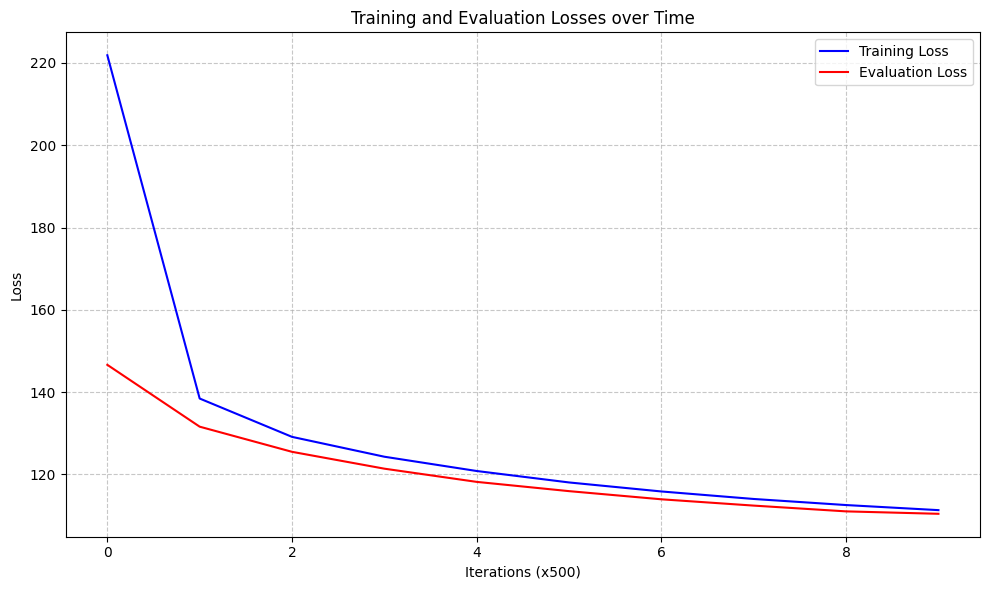

In [106]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

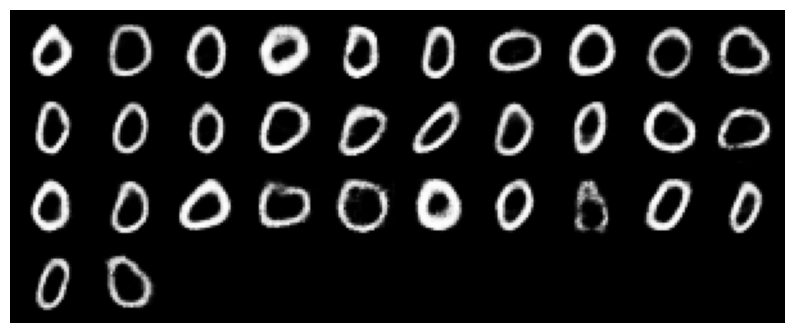

In [109]:
def visualize_generations(model, digit, num_examples):
    # Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images

    model.eval()

    digit_data = torch.cat([data[labels == digit] for data, labels in test_loader])
    digit_data = digit_data[:num_examples].to(DEVICE)

    with torch.no_grad():
        mu, logvar = model.encode(digit_data)
        z = model.reparametrize(mu, logvar)

        reconstructed_x = model.decode(z)

    plot_image(reconstructed_x)


digit = 0
num_examples = 32

visualize_generations(model, digit, num_examples)

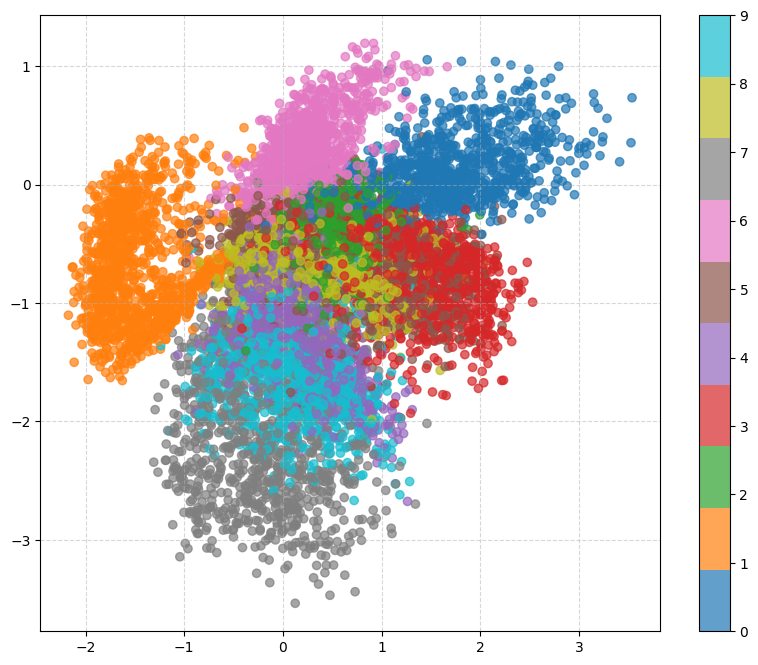

In [97]:
def visualize_latens(dataloader, model):
    # Implement the visualize_latens function
    # Set your model's latent space to 2 and train the model
    # Encode all samples from MNIST test loader to the latent space
    # Plot them using scatter plot to show how your model has been able differentiate between them

    model.eval()
    
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(DEVICE)
            
            mu, _ = model.encode(data)
            
            latents.append(mu.cpu())
            labels.append(label)
    
    latents = torch.cat(latents)
    labels = torch.cat(labels)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


visualize_latens(test_loader, model)